In [7]:
from sklearn import decomposition
import math
from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
# own modules
from text_embeddings.preprocessing.read_pdf import *
from user_interface.cli import *
from doc_images.pdf_matrix import *
from elasticSearch.queries.query_documents_tfidf import *
from text_embeddings.universal_sent_encoder_tensorFlow import *
from text_embeddings.hugging_face_sentence_transformer import *

image_src_path = '/Users/klara/Documents/Uni/bachelorarbeit/images/*.png'
IMG_SIZE = 600

In [8]:
image_paths = glob.glob(image_src_path)
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE**2) 
        for img in image_paths])

In [9]:

# center the images, cf. https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
# Global centering (focus on one feature, centering all samples)
preprocessed_images_centered = preprocessed_images - np.mean(preprocessed_images, axis=0)
# Local centering (focus on one sample, centering all features)
preprocessed_images_centered -= preprocessed_images_centered.mean(axis=1).reshape(len(preprocessed_images_centered), -1)

shape of all data:  (194, 360000)


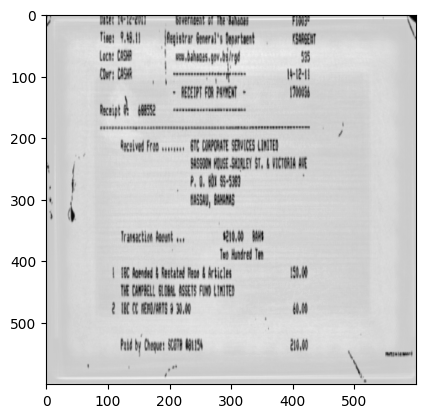

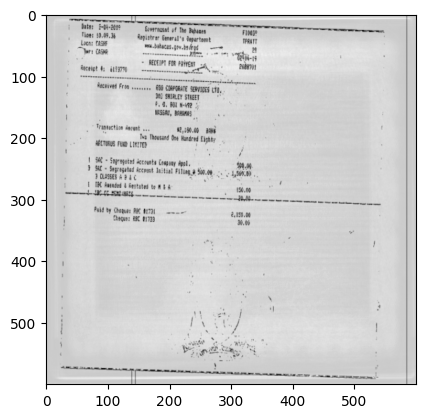

In [10]:

print('shape of all data: ', preprocessed_images_centered.shape)    # (n_samples, n_features)
for img in preprocessed_images_centered[:2]:
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.show()

In [11]:
# PCA needs more samples than features, cf. https://stackoverflow.com/questions/51040075/why-sklearn-pca-needs-more-samples-than-new-featuresn-components
# otherwise the number of new faetures will be way smaller than the original number of features
# number of components to keep: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
# SVD: https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors
pca = decomposition.PCA(n_components=194, svd_solver="randomized", whiten=True)
#print(preprocessed_images[0].shape)
pca_img = pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', pca.components_.shape)    # (n_new_features/ n_components, n_features)
print('PCA return shape: ', pca_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_img)

PCA components:  (194, 360000)
PCA return shape:  (194, 194)
PCA image:  [[-0.3464041  -0.32716826  0.23464695 ... -0.1935737  -0.26627257
   0.99741834]
 [-0.36625168  0.29769933  0.5297081  ... -0.46884304 -0.06701101
   0.99742144]
 [ 0.56696993  0.20514877  9.159809   ... -0.31909505  0.17383812
   0.99742097]
 ...
 [-0.20440617 -0.48254195 -0.04636144 ...  0.22855033 -0.0187571
   0.9974218 ]
 [ 3.364787    1.413438   -0.38215497 ... -0.02487659  0.07398795
   0.9974191 ]
 [-0.38864115 -0.08934378 -0.4395213  ... -0.11495251  0.07870983
   0.9974211 ]]


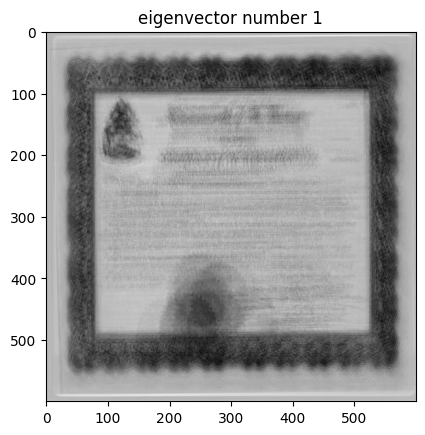

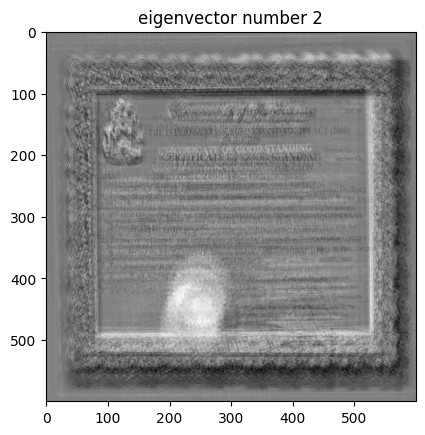

In [12]:
# plot eigenvectors as images
i = 1
for img in pca.components_[:2]: # component is (parallel to) eigenvector, cf. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title('eigenvector number ' + str(i))
    i += 1
    plt.show()

    # compare eigenvectors to get 'what they show (eg. Belichtung, Kontrast, etc.)'
    # TODO: residuals/ rescosntruction error, to see how much information is lost, if representative

In [13]:
# save representation of images in lower dimension (linear combination of eigenvectors) in dataframe
pca_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_img[i]], index=pca_df.index[[i]])

pca_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.3464041, -0.32716826, 0.23464695, 0.838580..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36625168, 0.29769933, 0.5297081, -0.025587..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.56696993, 0.20514877, 9.159809, 1.9111564, ..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844565, 0.3091863, 0.7689311, 0.3912142,..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365487, -0.4241956, -0.54464847, -0.1786..."
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.3154921, -0.07029349, -0.6786967, -0.00198..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.300406, 0.053367183, 0.16822042, 0.2597990..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440617, -0.48254195, -0.046361435, 0.087..."


In [14]:
# identify clusters by similar weights (linear combination) of eigenvectors
NUM_CLASSES = 4
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_df['pca_weights'].to_list())
pca_df['cluster'] = kmeans.labels_
display(pca_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.3464041, -0.32716826, 0.23464695, 0.838580...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36625168, 0.29769933, 0.5297081, -0.025587...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.56696993, 0.20514877, 9.159809, 1.9111564, ...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844565, 0.3091863, 0.7689311, 0.3912142,...",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365487, -0.4241956, -0.54464847, -0.1786...",1
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.3154921, -0.07029349, -0.6786967, -0.00198...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.300406, 0.053367183, 0.16822042, 0.2597990...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440617, -0.48254195, -0.046361435, 0.087...",3


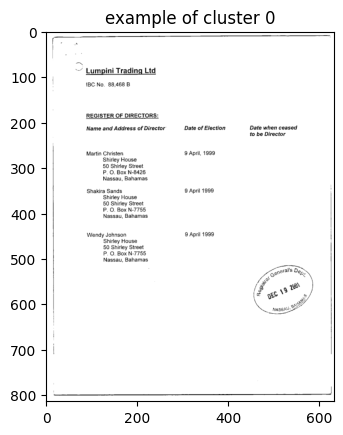

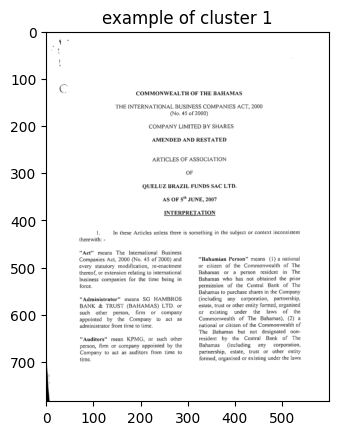

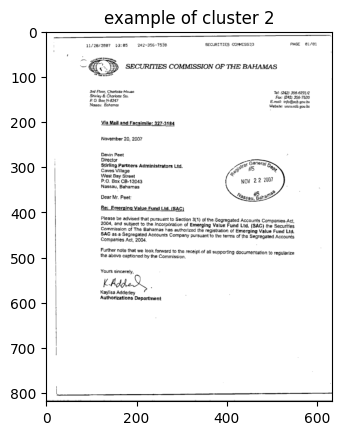

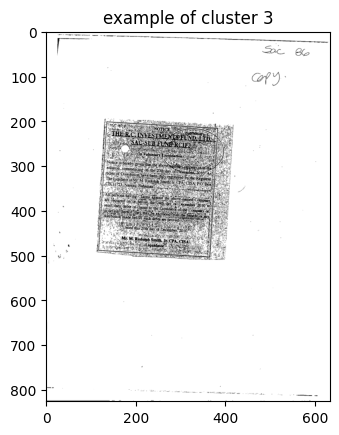

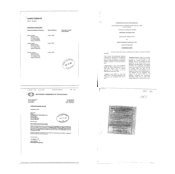

In [15]:
# display sample document per class
example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_df[pca_df['cluster'] == i].sample(1).index.values[0]
    example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of cluster ' + str(i))
    plt.show()

create_image_matrix(example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

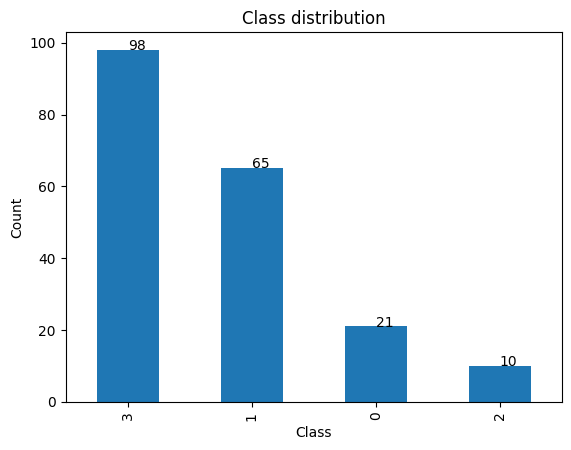

In [16]:
# class/ cluster distribution
pca_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
cluster_counts = pca_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_df['cluster'].value_counts())):
        plt.text(i, cluster_counts[i], cluster_counts[i])

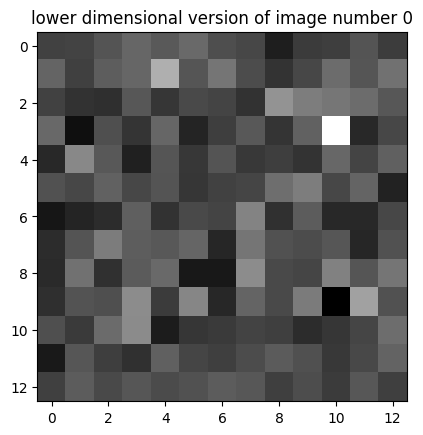

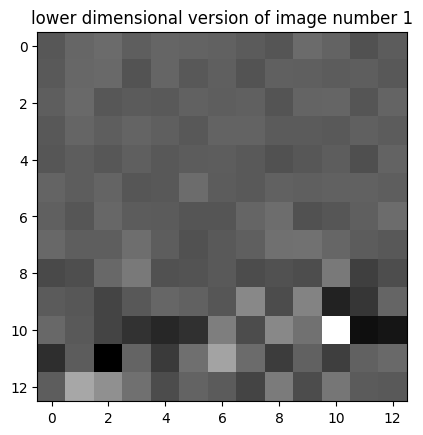

In [17]:
# visualize the compressed data, i.e. the weights/ factors of PCA components, as an image
# transformed pictures in lower dimensional subspace (weights of PCA components)
for i in range(len(pca_img[:2])):
    img = pca_img[i]
    dim = int(sqrt(len(img)))
    # automatically transform image using -1, cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
    quadratic_img = img[:dim**2].reshape(-1, dim)#img[:dim**2].reshape(dim, dim)
    plt.imshow(quadratic_img, cmap='gray')
    plt.title('lower dimensional version of image number ' + str(i))
    plt.show()

In [18]:
# use PCA to reduce dimensionality (image -> point in 2 dimensional space)
# cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
# SVD: https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors
d2_pca = decomposition.PCA(n_components=2, svd_solver="randomized", whiten=True)
#print(preprocessed_images[0].shape)
pca_2d_img = d2_pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', d2_pca.components_.shape, 'Principal axes in feature space = directions of maximum variance')    # (n_new_features/ n_components, n_features)
print('PCA return/ image shape: ', pca_2d_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_2d_img)

PCA components:  (2, 360000) Principal axes in feature space = directions of maximum variance
PCA return/ image shape:  (194, 2)
PCA image:  [[-3.46403807e-01 -3.27827692e-01]
 [-3.66249532e-01  2.97313482e-01]
 [ 5.66972017e-01  2.01831266e-01]
 [-2.88445204e-01  3.08468342e-01]
 [-4.33654666e-01 -4.23689455e-01]
 [-3.60889018e-01  3.51097107e-01]
 [-4.89750355e-01 -3.33492249e-01]
 [-4.69095528e-01 -2.16631517e-01]
 [-2.59473711e-01 -1.35572836e-01]
 [ 2.68318987e+00  1.91440701e+00]
 [-4.73634094e-01 -4.84997809e-01]
 [-5.46603739e-01  1.04475103e-01]
 [ 3.07976675e+00  2.32903615e-01]
 [-4.15832579e-01 -8.60787183e-02]
 [-1.90707043e-01  2.15063810e-01]
 [-4.07719731e-01  1.73681200e-01]
 [-2.66362846e-01  5.73635280e-01]
 [-3.82631063e-01  4.15104404e-02]
 [-1.74659669e-01  2.52646446e-01]
 [-3.16851377e-01  2.34457359e-01]
 [-2.79991269e-01 -2.79391229e-01]
 [-2.27828547e-01 -1.70157388e-01]
 [-3.84884685e-01 -5.07207274e-01]
 [-5.38831949e-01 -6.43930376e-01]
 [-5.22882402e-01 -

In [19]:
# save representation of images by linear combination of eigenvectors in dataframe
pca_2d_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_2d_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_2d_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_2d_img[i]], index=pca_2d_df.index[[i]])

pca_2d_df.to_json('pca_2d_df.json', index=True)
pca_2d_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.3464038, -0.3278277]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36624953, 0.29731348]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.566972, 0.20183127]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.2884452, 0.30846834]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365467, -0.42368945]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549233, -0.06991515]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040598, 0.053121667]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440646, -0.4827521]"


In [20]:
# identify clusters by similar weights (linear combination) of eigenvectors
d2_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['cluster'] = d2_kmeans.labels_
display(pca_2d_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.3464038, -0.3278277]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36624953, 0.29731348]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.566972, 0.20183127]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.2884452, 0.30846834]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365467, -0.42368945]",0
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549233, -0.06991515]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040598, 0.053121667]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440646, -0.4827521]",0


Text(0.5, 1.0, '2D representation of images clustered by KMeans')

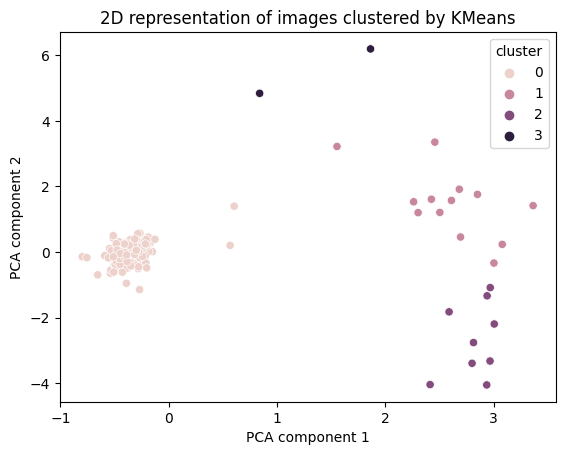

In [21]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by KMeans')

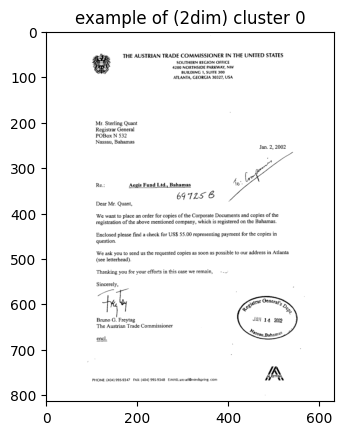

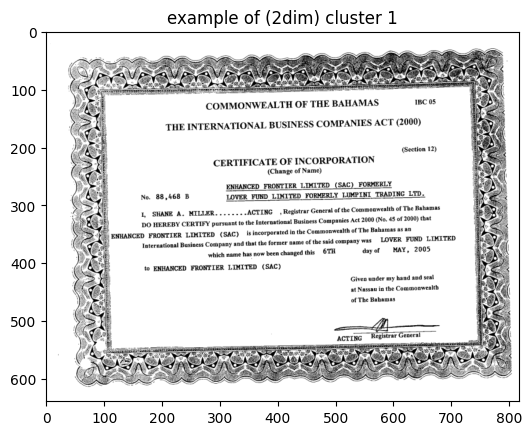

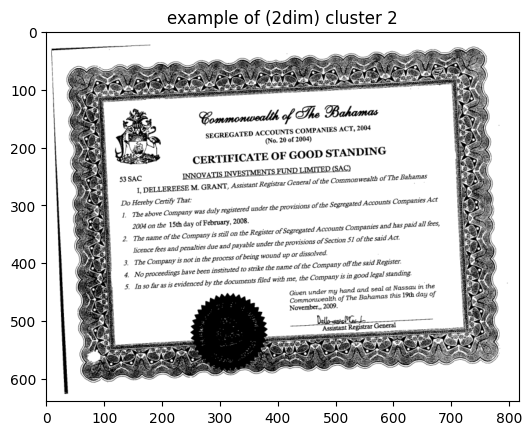

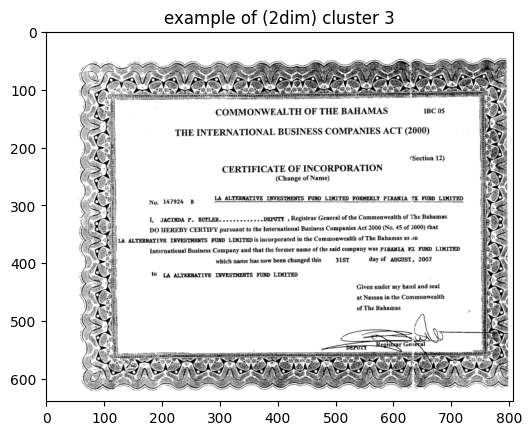

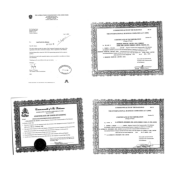

In [22]:
# display sample document per class
d2_example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_2d_df[pca_2d_df['cluster'] == i].sample(1).index.values[0]
    d2_example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of (2dim) cluster ' + str(i))
    plt.show()

create_image_matrix(d2_example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

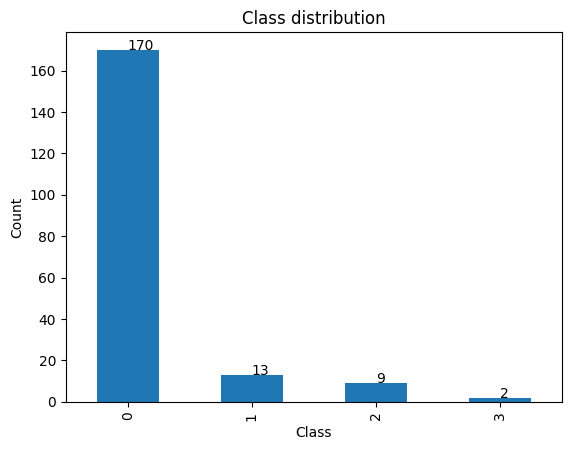

In [23]:
# class/ cluster distribution
pca_2d_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
d2_cluster_counts = pca_2d_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_2d_df['cluster'].value_counts())):
        plt.text(i, d2_cluster_counts[i], d2_cluster_counts[i])

# PCA

### PCA components: 
- Principal axes in feature space = directions of maximum variance
- Parallel to eigenvectors

### PCA explained variance:
- Amount of variance explained by each of the selected components
- Ratio: same, but percentage

### PCA n_components:
- Number of components to keep

### PCA return values:
- samples in new (lower dimensional) feature space
